In [28]:
# Preprocessing
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import regex as re

# from workalendar.europe import France

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor, Pool
from prophet import Prophet

plt.style.use("fivethirtyeight")

path = Path.cwd().parent / "mdsb-2023"

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    LabelEncoder,
    OrdinalEncoder,
    StandardScaler,
)

import xgboost as xgb
from timeit import default_timer as timer

plt.style.use("fivethirtyeight")

### General functions

In [56]:
def train_test_split_temporal(X, y, delta_threshold="60 days", date_col="date"):

    cutoff_date = X[date_col].max() - pd.Timedelta(delta_threshold)
    mask = X[date_col] <= cutoff_date
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [21]:
def add_lags(X, cols_to_lag=["t", "u", "vv", "nnuage4"], lag_list=[2, -24, -2]):
    X = X.copy()

    feature_columns = [col for col in X.columns if col in cols_to_lag]

    for l in lag_list:
        lag_columns = [f"{col}_lag{l}" for col in feature_columns]
        X[lag_columns] = X[feature_columns].shift(periods=l, axis=0)
        X[lag_columns] = (
            X[lag_columns]
            .interpolate(method="linear")
            .interpolate(method="bfill")
            .interpolate(method="ffill")
        )

    return X


def add_moving_average(
    X, cols_to_ma=["t", "u", "vv", "nnuage4"], window_list=[24 * 7, 24], centered=True
):
    X = X.copy()

    feature_columns = [col for col in X.columns if col in cols_to_ma]

    for w in window_list:
        ma_columns = [f"{col}_ma{w}" for col in feature_columns]
        X[ma_columns] = X[feature_columns].rolling(window=w, center=centered).mean()
        X[ma_columns] = (
            X[ma_columns]
            .interpolate(method="linear")
            .interpolate(method="bfill")
            .interpolate(method="ffill")
        )

    return X

### Pipeline functions

In [70]:
def _encode_dates(X, col_name="date"):
    X = X.copy()

    X["month"] = X[col_name].dt.month
    X["weekday"] = X[col_name].dt.weekday
    X["hour"] = X[col_name].dt.hour

    X["month_sin"] = np.sin(2 * np.pi * X["date"].dt.month / 12)
    X["month_cos"] = np.cos(2 * np.pi * X["date"].dt.month / 12)

    X["day_sin"] = np.sin(2 * np.pi * X["date"].dt.day / X["date"].dt.days_in_month)
    X["day_cos"] = np.cos(2 * np.pi * X["date"].dt.day / X["date"].dt.days_in_month)

    X["hour_sin"] = np.sin(2 * np.pi * X["date"].dt.hour / 24)
    X["hour_cos"] = np.cos(2 * np.pi * X["date"].dt.hour / 24)

    X[["month", "weekday", "hour"]] = X[["month", "weekday", "hour"]].astype("category")

    return X.drop(columns=[col_name])


def _encode_covid(X, col_name="date"):
    X = X.copy()

    # Create masks for lockdown dates
    lockdown_1 = (X["date"] >= "2020-10-17") & (X["date"] <= "2020-12-14")

    lockdown_2 = (X["date"] >= "2020-12-15") & (X["date"] <= "2021-02-26")

    lockdown_3 = (X["date"] >= "2021-02-27") & (X["date"] <= "2021-05-02")

    X["Covid"] = 0
    X.loc[lockdown_1 | lockdown_2 | lockdown_3, "Covid"] = 1

    return X


def _merge_external_data(X, include_lags=True, include_ma=True):
    to_keep = [
        "date",
        "hnuage4",
        "t",
        "ctype4",
        "nnuage4",
        "u",
        "etat_sol",
        "perssfrai",
        "tx12",
        "cm",
        "tn12",
        "tend24",
        "vv",
        "rafper",
        "rr24",
        "hnuage2",
        "td",
        "rr3",
        "hnuage3",
        "hnuage1",
    ]

    ext_data = pd.read_csv(path / "external_data.csv", parse_dates=["date"])[to_keep]

    ext_data.drop(columns=ext_data.columns[ext_data.isna().sum() > 1000])

    full_date_range = pd.date_range(
        start=np.min([np.min(data.date), np.min(test.date)]),
        end=np.max([np.max(data.date), np.max(test.date)]),
        freq="H",
    )

    full_date_range = pd.DataFrame({"date": full_date_range})

    ext_data = full_date_range.merge(ext_data, on="date", how="left")

    columns_to_interpolate = ext_data.drop(columns="date").columns
    ext_data[columns_to_interpolate] = (
        ext_data[columns_to_interpolate]
        .interpolate(method="polynomial", order=3)
        .interpolate(method="bfill")
        .interpolate(method="ffill")
    )

    if include_lags:
        ext_data = add_lags(ext_data)

    if include_ma:
        ext_data = add_moving_average(ext_data)

    to_drop = [
        "vv_lag2",
        "t_lag-24",
        "u_lag-24",
        "vv_lag-24",
        "tx12",
        "nnuage4_lag-2",
        "etat_sol",
        "vv_lag-2",
        "u",
        "nnuage4",
        "ctype4",
        "t",
        "u_lag2",
        "vv_ma24",
        "t_lag2",
        "tend24",
        "u_ma24",
        "nnuage4_ma24",
        "vv_ma168",
        "cm",
        "hnuage1",
        "hnuage3",
        "rr3",
        "td",
        "hnuage2",
        "rr24",
        "rafper",
        "vv",
        "u_ma168",
        "hnuage4",
    ]

    ext_data.drop(columns=to_drop, inplace=True)

    X = X.copy()

    X["date"] = X["date"].astype("datetime64[ns]")
    ext_data["date"] = ext_data["date"].astype("datetime64[ns]")

    X["orig_index"] = np.arange(X.shape[0])

    X = pd.merge_asof(X.sort_values("date"), ext_data.sort_values("date"), on="date")

    # Sort back to the original order
    X = X.sort_values("orig_index")
    del X["orig_index"]

    return X


def _gas_price_encoder(X):
    X = X.copy()
    X["gas_price"] = 1

    gas_prices = np.array(
        [
            1.22,
            1.21,
            1.22,
            1.27,
            1.31,
            1.36,
            1.4,
            1.39,
            1.4,
            1.43,
            1.45,
            1.45,
            1.46,
            1.56,
        ]
    )

    years = [
        2020,
        2020,
        2020,
        2020,
        2021,
        2021,
        2021,
        2021,
        2021,
        2021,
        2021,
        2021,
        2021,
        2021,
    ]

    months = [9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

    for i, price in enumerate(gas_prices):
        X.loc[
            (X.date.dt.month == months[i]) & (X.date.dt.year == years[i]), "gas_price"
        ] = price

    return X


def full_encode(X):
    return _encode_dates(
        _encode_covid(_gas_price_encoder(_merge_external_data(_merge_prophet(X))))
    )

### Model functions

In [23]:
def prophet_fit_pred(
    data, group, test_delta=pd.Timedelta("60 days"), plot_components=False
):
    data = data.copy()
    data["floor"] = 0

    data = data[
        data["group"] == group
    ]  # To test on a single group only, for simplicity

    data = data[["ds", "y"]]

    # Define the test set for prophet as the last 60 days
    cutoff_date = data["ds"].max() - test_delta
    mask = data["ds"] <= cutoff_date
    train_prophet, test_prophet = data.loc[mask], data.loc[~mask]

    # Initialize the model
    prophet = Prophet(
        interval_width=0.95,
        growth="linear",
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=False,
        seasonality_mode="multiplicative",
    )

    # Add French holidays
    prophet.add_country_holidays(country_name="FR")

    prophet.fit(train_prophet)

    future = prophet.make_future_dataframe(
        periods=test_delta.days * 24, freq="h", include_history=True
    )

    # predict over the dataset
    components = prophet.predict(future)

    pred = components.iloc[-60 * 24 :, [0, -1]]  # Only keep the predicted

    if plot_components:
        prophet.plot_components(components)

    return pred, test_prophet, components

In [78]:
def _merge_prophet(X):
    X = X.copy()

    X["orig_index"] = np.arange(X.shape[0])
    X = pd.merge(
        X.sort_values(["date", "counter_name"]),
        prophet_fit.sort_values(["date", "counter_name"]),
        on=["date", "counter_name"],
    )

    # Sort back to the original order
    X = X.sort_values("orig_index")
    del X["orig_index"]
    return X

In [79]:
def get_pipeline():
    prophet_merger = FunctionTransformer(_merge_prophet, validate=False)
    data_merger = FunctionTransformer(_merge_external_data, validate=False)
    covid_encoder = FunctionTransformer(_encode_covid, validate=False)
    gas_encoder = FunctionTransformer(_gas_price_encoder, validate=False)
    date_encoder = FunctionTransformer(_encode_dates, validate=False)

    best_params = {
        "learning_rate": 0.16,
        "max_depth": 8,
        "n_estimators": 630,
        "subsample": 0.8,
        "od_pval": 1e-5,
    }

    regressor = CatBoostRegressor(**best_params)

    pipe = Pipeline(
        [
            ("merge prophet", prophet_merger),
            ("merge external", data_merger),
            ("gas prices encoder", gas_encoder),
            ("covid encoder", covid_encoder),
            ("date encoder", date_encoder),
            ("regressor", regressor),
        ]
    )

    return pipe

## Import main dataset

In [80]:
data = pd.read_parquet(path / "train.parquet")
test = pd.read_parquet(path / "final_test.parquet")

targets = ["bike_count", "log_bike_count"]

In [81]:
data.drop(
    columns=[
        "site_name",
        "counter_id",
        "site_id",
        "counter_installation_date",
        "coordinates",
        "counter_technical_id",
    ],
    inplace=True,
)
test.drop(
    columns=[
        "site_name",
        "counter_id",
        "site_id",
        "counter_installation_date",
        "coordinates",
        "counter_technical_id",
    ],
    inplace=True,
)

## Prophet

In [27]:
y_hat = pd.DataFrame(columns=["ds", "yhat", "group"])
y_true = pd.DataFrame(columns=["ds", "y", "group"])

forecast = pd.DataFrame()

for i, grp in enumerate(data["counter_name"].unique()):

    print(f"\n==[ Start group [{i+1}/{data['counter_name'].nunique()}] ]==")

    data_prophet = data.rename(
        columns={"date": "ds", "log_bike_count": "y", "counter_name": "group"}
    ).sort_values(["group", "ds"])

    pred, test, components = prophet_fit_pred(data_prophet, grp)
    components["group"] = grp
    pred["group"] = grp
    test["group"] = grp

    forecast = pd.concat([forecast, components])

    # Saving in the full datasets
    y_hat = pd.concat([y_hat, pred])
    y_true = pd.concat([y_true, test])


==[ Start group [0/56] ]==


00:01:47 - cmdstanpy - INFO - Chain [1] start processing
00:01:48 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [1/56] ]==


00:01:51 - cmdstanpy - INFO - Chain [1] start processing
00:01:52 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [2/56] ]==


00:01:55 - cmdstanpy - INFO - Chain [1] start processing
00:01:56 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [3/56] ]==


00:01:59 - cmdstanpy - INFO - Chain [1] start processing
00:01:59 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [4/56] ]==


00:02:03 - cmdstanpy - INFO - Chain [1] start processing
00:02:04 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [5/56] ]==


00:02:07 - cmdstanpy - INFO - Chain [1] start processing
00:02:08 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [6/56] ]==


00:02:11 - cmdstanpy - INFO - Chain [1] start processing
00:02:12 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [7/56] ]==


00:02:15 - cmdstanpy - INFO - Chain [1] start processing
00:02:16 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [8/56] ]==


00:02:19 - cmdstanpy - INFO - Chain [1] start processing
00:02:20 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [9/56] ]==


00:02:23 - cmdstanpy - INFO - Chain [1] start processing
00:02:24 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [10/56] ]==


00:02:27 - cmdstanpy - INFO - Chain [1] start processing
00:02:28 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [11/56] ]==


00:02:31 - cmdstanpy - INFO - Chain [1] start processing
00:02:32 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [12/56] ]==


00:02:35 - cmdstanpy - INFO - Chain [1] start processing
00:02:35 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [13/56] ]==


00:02:39 - cmdstanpy - INFO - Chain [1] start processing
00:02:39 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [14/56] ]==


00:02:43 - cmdstanpy - INFO - Chain [1] start processing
00:02:43 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [15/56] ]==


00:02:46 - cmdstanpy - INFO - Chain [1] start processing
00:02:47 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [16/56] ]==


00:02:50 - cmdstanpy - INFO - Chain [1] start processing
00:02:51 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [17/56] ]==


00:02:54 - cmdstanpy - INFO - Chain [1] start processing
00:02:54 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [18/56] ]==


00:02:57 - cmdstanpy - INFO - Chain [1] start processing
00:02:58 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [19/56] ]==


00:03:01 - cmdstanpy - INFO - Chain [1] start processing
00:03:03 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [20/56] ]==


00:03:05 - cmdstanpy - INFO - Chain [1] start processing
00:03:07 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [21/56] ]==


00:03:10 - cmdstanpy - INFO - Chain [1] start processing
00:03:11 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [22/56] ]==


00:03:14 - cmdstanpy - INFO - Chain [1] start processing
00:03:15 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [23/56] ]==


00:03:18 - cmdstanpy - INFO - Chain [1] start processing
00:03:19 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [24/56] ]==


00:03:22 - cmdstanpy - INFO - Chain [1] start processing
00:03:23 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [25/56] ]==


00:03:26 - cmdstanpy - INFO - Chain [1] start processing
00:03:27 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [26/56] ]==


00:03:30 - cmdstanpy - INFO - Chain [1] start processing
00:03:30 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [27/56] ]==


00:03:33 - cmdstanpy - INFO - Chain [1] start processing
00:03:34 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [28/56] ]==


00:03:37 - cmdstanpy - INFO - Chain [1] start processing
00:03:38 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [29/56] ]==


00:03:41 - cmdstanpy - INFO - Chain [1] start processing
00:03:42 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [30/56] ]==


00:03:45 - cmdstanpy - INFO - Chain [1] start processing
00:03:46 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [31/56] ]==


00:03:49 - cmdstanpy - INFO - Chain [1] start processing
00:03:50 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [32/56] ]==


00:03:53 - cmdstanpy - INFO - Chain [1] start processing
00:03:54 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [33/56] ]==


00:03:57 - cmdstanpy - INFO - Chain [1] start processing
00:03:58 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [34/56] ]==


00:04:01 - cmdstanpy - INFO - Chain [1] start processing
00:04:02 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [35/56] ]==


00:04:05 - cmdstanpy - INFO - Chain [1] start processing
00:04:05 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [36/56] ]==


00:04:08 - cmdstanpy - INFO - Chain [1] start processing
00:04:09 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [37/56] ]==


00:04:12 - cmdstanpy - INFO - Chain [1] start processing
00:04:13 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [38/56] ]==


00:04:16 - cmdstanpy - INFO - Chain [1] start processing
00:04:17 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [39/56] ]==


00:04:20 - cmdstanpy - INFO - Chain [1] start processing
00:04:20 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [40/56] ]==


00:04:23 - cmdstanpy - INFO - Chain [1] start processing
00:04:24 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [41/56] ]==


00:04:27 - cmdstanpy - INFO - Chain [1] start processing
00:04:28 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [42/56] ]==


00:04:31 - cmdstanpy - INFO - Chain [1] start processing
00:04:32 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [43/56] ]==


00:04:35 - cmdstanpy - INFO - Chain [1] start processing
00:04:36 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [44/56] ]==


00:04:39 - cmdstanpy - INFO - Chain [1] start processing
00:04:40 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [45/56] ]==


00:04:43 - cmdstanpy - INFO - Chain [1] start processing
00:04:44 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [46/56] ]==


00:04:46 - cmdstanpy - INFO - Chain [1] start processing
00:04:47 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [47/56] ]==


00:04:50 - cmdstanpy - INFO - Chain [1] start processing
00:04:51 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [48/56] ]==


00:04:54 - cmdstanpy - INFO - Chain [1] start processing
00:04:55 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [49/56] ]==


00:04:58 - cmdstanpy - INFO - Chain [1] start processing
00:04:59 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [50/56] ]==


00:05:01 - cmdstanpy - INFO - Chain [1] start processing
00:05:02 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [51/56] ]==


00:05:05 - cmdstanpy - INFO - Chain [1] start processing
00:05:06 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [52/56] ]==


00:05:09 - cmdstanpy - INFO - Chain [1] start processing
00:05:10 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [53/56] ]==


00:05:13 - cmdstanpy - INFO - Chain [1] start processing
00:05:15 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [54/56] ]==


00:05:18 - cmdstanpy - INFO - Chain [1] start processing
00:05:18 - cmdstanpy - INFO - Chain [1] done processing



==[ Start group [55/56] ]==


00:05:20 - cmdstanpy - INFO - Chain [1] start processing
00:05:21 - cmdstanpy - INFO - Chain [1] done processing


In [48]:
print(
    f"Test set, RMSE={mean_squared_error(y_true.iloc[:,1], y_hat.iloc[:,1], squared=False):.2f}"
)

Test set, RMSE=1.12


In [86]:
prophet_fit = forecast.copy()
prophet_fit.rename(columns=lambda c: re.sub(r"'", "", c), inplace=True)
prophet_fit.rename(columns=lambda c: re.sub(r"\s+", "", c), inplace=True)

selected_cols = [
    "ds",
    "ChristmasDay",
    "NewYearsDay",
    "daily",
    "weekly",
    # "yhat",
    "group",
]

prophet_fit = prophet_fit[selected_cols]
prophet_fit = prophet_fit.rename(
    columns={"ds": "date", "group": "counter_name"}
).sort_values(
    by=["counter_name", "date"]
)  # This can be merged to main dataset for extra features for the ml model

00:16:00 - cmdstanpy - INFO - Chain [1] start processing
00:16:00 - cmdstanpy - INFO - Chain [1] done processing


(                      ds      yhat
 5137 2021-07-12 00:00:00  0.896659
 5138 2021-07-12 01:00:00  0.678016
 5139 2021-07-12 02:00:00  0.770190
 5140 2021-07-12 03:00:00  1.342621
 5141 2021-07-12 04:00:00  2.386609
 ...                  ...       ...
 6572 2021-09-09 19:00:00  4.948915
 6573 2021-09-09 20:00:00  4.054731
 6574 2021-09-09 21:00:00  3.110136
 6575 2021-09-09 22:00:00  2.322521
 6576 2021-09-09 23:00:00  1.742370
 
 [1440 rows x 2 columns],
                         ds         y
 927636 2021-07-12 00:00:00  0.693147
 925187 2021-07-12 01:00:00  1.098612
 925190 2021-07-12 02:00:00  1.098612
 927889 2021-07-12 03:00:00  1.609438
 927892 2021-07-12 04:00:00  2.944439
 ...                    ...       ...
 929155 2021-09-09 19:00:00  4.477337
 926678 2021-09-09 20:00:00  4.025352
 926681 2021-09-09 21:00:00  3.891820
 929184 2021-09-09 22:00:00  3.091042
 929187 2021-09-09 23:00:00  2.772589
 
 [1440 rows x 2 columns],
                       ds     trend  yhat_lower  yhat_up

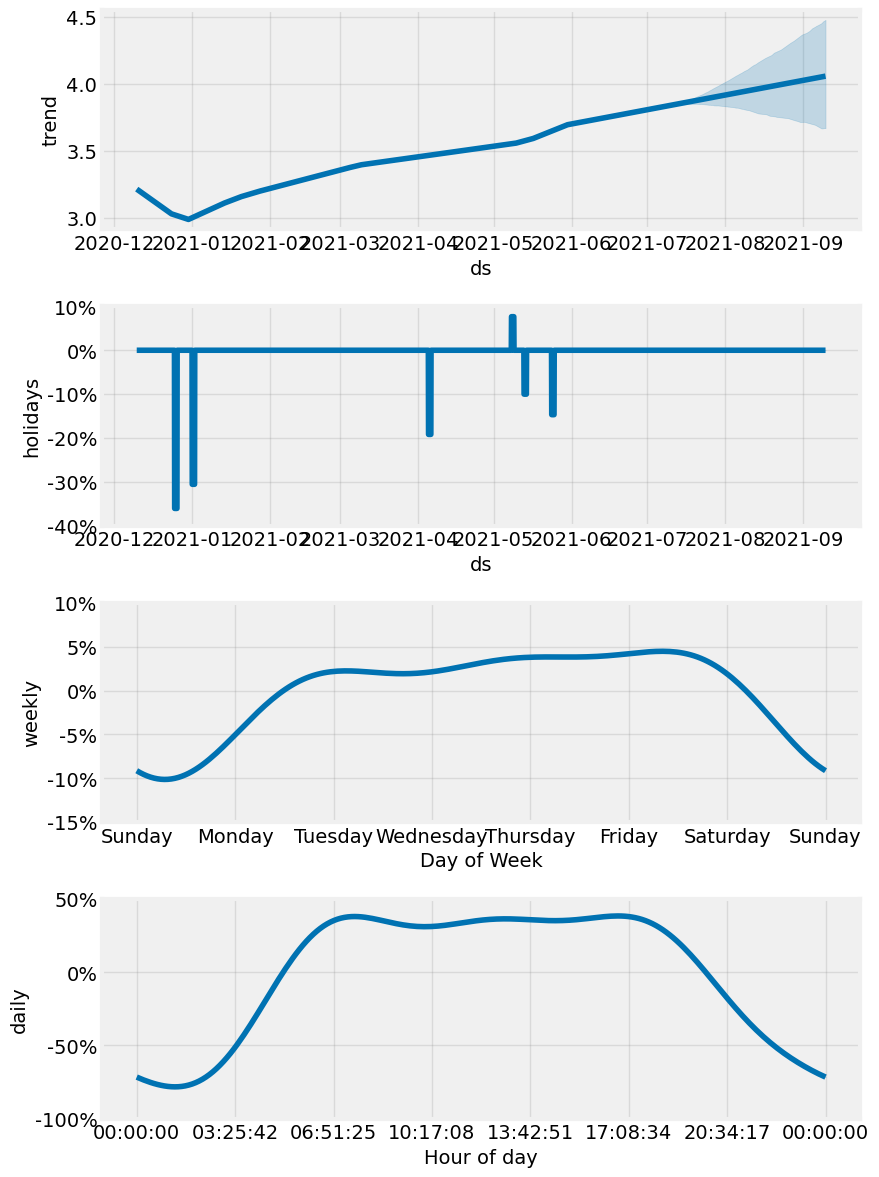

In [53]:
prophet_fit_pred(data_prophet, grp, plot_components=True)

## CatBoost

In [87]:
X, y = data.drop(columns=targets), data["log_bike_count"]

date_cols = (
    _encode_dates(X[["date"]]).select_dtypes(include="category").columns.tolist()
)
categorical_cols = ["counter_name"] + date_cols

In [88]:
X_train, y_train, X_test, y_test = train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Test: n_samples={X_test.shape[0]},  {X_test["date"].min()} to {X_test["date"].max()}'
)

Train: n_samples=416187,  2020-09-01 01:00:00 to 2021-07-11 23:00:00
Test: n_samples=80640,  2021-07-12 00:00:00 to 2021-09-09 23:00:00


In [89]:
pipe = get_pipeline()

val_pool = Pool(
    full_encode(X_test),
    label=y_test,
    cat_features=categorical_cols,
)

pipe.fit(
    X_train,
    y_train,
    regressor__cat_features=categorical_cols,
    regressor__early_stopping_rounds=70,
    regressor__eval_set=val_pool,
)

0:	learn: 1.4982380	test: 1.2873456	best: 1.2873456 (0)	total: 442ms	remaining: 4m 38s
1:	learn: 1.3354651	test: 1.1362728	best: 1.1362728 (1)	total: 831ms	remaining: 4m 21s
2:	learn: 1.2017931	test: 1.0105850	best: 1.0105850 (2)	total: 1.17s	remaining: 4m 4s
3:	learn: 1.0943791	test: 0.9175879	best: 0.9175879 (3)	total: 1.5s	remaining: 3m 55s
4:	learn: 1.0063404	test: 0.8449391	best: 0.8449391 (4)	total: 1.81s	remaining: 3m 46s
5:	learn: 0.9394797	test: 0.7911370	best: 0.7911370 (5)	total: 2.03s	remaining: 3m 31s
6:	learn: 0.8813140	test: 0.7441812	best: 0.7441812 (6)	total: 2.25s	remaining: 3m 19s
7:	learn: 0.8331077	test: 0.7261601	best: 0.7261601 (7)	total: 2.47s	remaining: 3m 12s
8:	learn: 0.7984033	test: 0.7072864	best: 0.7072864 (8)	total: 2.72s	remaining: 3m 7s
9:	learn: 0.7663458	test: 0.6926627	best: 0.6926627 (9)	total: 2.98s	remaining: 3m 4s
10:	learn: 0.7268393	test: 0.6780925	best: 0.6780925 (10)	total: 3.23s	remaining: 3m 1s
11:	learn: 0.6963566	test: 0.6781750	best: 0.6

Pipeline(steps=[('merge prophet',
                 FunctionTransformer(func=<function _merge_prophet at 0x000002D7896A60E0>)),
                ('merge external',
                 FunctionTransformer(func=<function _merge_external_data at 0x000002D78C67A560>)),
                ('gas prices encoder',
                 FunctionTransformer(func=<function _gas_price_encoder at 0x000002D78C67AD40>)),
                ('covid encoder',
                 FunctionTransformer(func=<function _encode_covid at 0x000002D78C67BAC0>)),
                ('date encoder',
                 FunctionTransformer(func=<function _encode_dates at 0x000002D78C6784C0>)),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x000002D790F01360>)])

In [90]:
y_hat = pipe.predict(X_test)
y_hat[y_hat < 0] = 0

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(f"Test set, RMSE={mean_squared_error(y_test, y_hat, squared=False):.2f}")

Train set, RMSE=0.40
Test set, RMSE=0.64
